In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test, init_detector, inference_detector, show_result_pyplot
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

apex is not installed
apex is not installed
apex is not installed
apex is not installed


In [2]:
classes = ("UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
#get config file
#cfg = Config.fromfile('/opt/ml/code/Swin-Transformer-Object-Detection-master/configs/swin/mask_rcnn_swin_small_patch4_window7_mstrain_480-800_adamw_3x_coco.py')
#cfg = Config.fromfile('/opt/ml/code/Swin-Transformer-Object-Detection-master/configs/swin/cascade_mask_rcnn_swin_base_patch4_window7_mstrain_480-800_giou_4conv1f_adamw_3x_coco.py')
#cfg = Config.fromfile('/opt/ml/code/Swin-Transformer-Object-Detection-master/configs/swin/cascade_mask_rcnn_swin_small_patch4_window7_mstrain_480-800_giou_4conv1f_adamw_3x_coco.py')
cfg = Config.fromfile('/opt/ml/code/Swin-Transformer-Object-Detection-master/configs/swin/cascade_mask_rcnn_swin_base.py')

PREFIX = '/opt/ml/input/data/'

epoch = 2

# dataset 바꾸기
cfg.data.train.classes = classes
cfg.data.train.img_prefix = PREFIX
cfg.data.train.ann_file = PREFIX + 'train.json'
#cfg.data.train.pipeline[2]['img_scale'] = (512, 512)

cfg.data.val.classes = classes
cfg.data.val.img_prefix = PREFIX
cfg.data.val.ann_file = PREFIX + 'val.json'
#cfg.data.val.pipeline[1]['img_scale'] = (512, 512)

cfg.data.test.classes = classes
cfg.data.test.img_prefix = PREFIX
cfg.data.test.ann_file = PREFIX + 'test.json'
#cfg.data.test.pipeline[0]['img_scale'] = (512, 512)

cfg.data.samples_per_gpu = 4

cfg.seed=42
cfg.gpu_ids = [0]
cfg.work_dir = './work_dirs/htc swin small'

#cfg.model.roi_head.bbox_head.num_classes = 11

#cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'epoch_{epoch}.pth')

In [3]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

2021-05-20 09:37:17,511 - mmdet - INFO - load model from: /opt/ml/code/Swin-Transformer-Object-Detection-master/work_dirs/cascade pafpn base with small/swin_base_patch4_window7_224_22k (1).pth
2021-05-20 09:37:18,595 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: norm.weight, norm.bias, head.weight, head.bias, layers.0.blocks.1.attn_mask, layers.1.blocks.1.attn_mask, layers.2.blocks.1.attn_mask, layers.2.blocks.3.attn_mask, layers.2.blocks.5.attn_mask, layers.2.blocks.7.attn_mask, layers.2.blocks.9.attn_mask, layers.2.blocks.11.attn_mask, layers.2.blocks.13.attn_mask, layers.2.blocks.15.attn_mask, layers.2.blocks.17.attn_mask

missing keys in source state_dict: norm0.weight, norm0.bias, norm1.weight, norm1.bias, norm2.weight, norm2.bias, norm3.weight, norm3.bias

Use load_from_local loader


In [5]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 837/837, 3.9 task/s, elapsed: 216s, ETA:     0s

In [6]:
from ensemble_boxes import *
iou_thr =0.5
skip_box_thr =0.0001
sigma = 0.1

#boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
#boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
#boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

NameError: name 'boxes_list' is not defined

In [6]:
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
imag_ids = coco.getImgIds()

class_num = 11
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        if len(out[0][j])>0:
            for o in out[0][j]:
                prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,8 0.99653935 174.80957 234.21814 461.15826 469...,batch_01_vt/0021.jpg
1,1 0.94794565 1.8595581 246.88245 303.9768 459....,batch_01_vt/0028.jpg
2,1 0.9188085 71.92735 167.99896 372.33813 375.9...,batch_01_vt/0031.jpg
3,2 0.2077216 297.7501 158.21767 364.63437 225.8...,batch_01_vt/0032.jpg
4,1 0.7529116 389.4828 272.6323 474.09546 343.80...,batch_01_vt/0070.jpg


Use load_from_local loader
/opt/ml/code/Swin-Transformer-Object-Detection-master/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/opt/ml/code/Swin-Transformer-Object-Detection-master/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


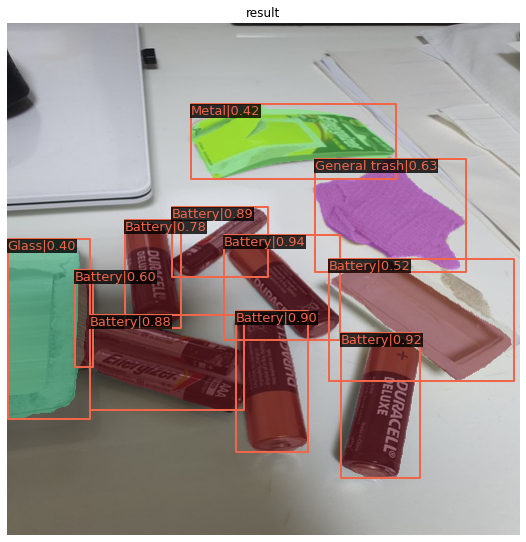

In [7]:
model = init_detector(cfg,checkpoint_path,device='cuda:0')
model.CLASSES = dataset.CLASSES
img = '/opt/ml/input/data/batch_01_vt/0334.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

Use load_from_local loader
/opt/ml/code/Swin-Transformer-Object-Detection-master/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


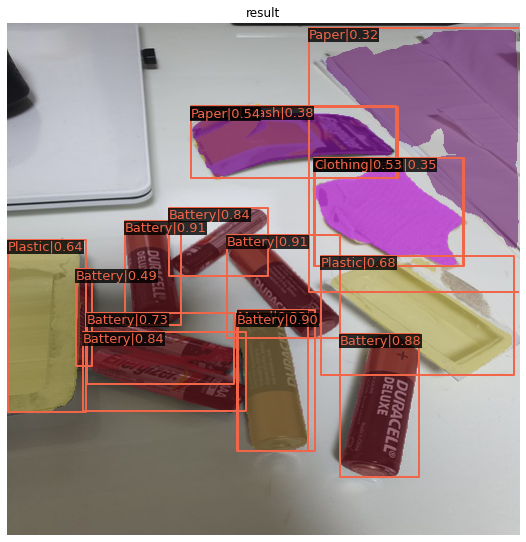

In [9]:
model = init_detector(cfg,checkpoint_path,device='cuda:0')
model.CLASSES = dataset.CLASSES
img = '/opt/ml/input/data/batch_01_vt/0334.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

Use load_from_local loader
/opt/ml/code/Swin-Transformer-Object-Detection-master/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/opt/ml/code/Swin-Transformer-Object-Detection-master/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


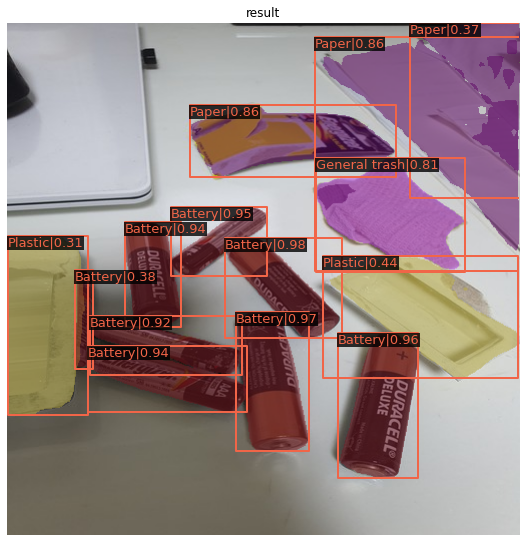

In [7]:
model = init_detector(cfg,checkpoint_path,device='cuda:0')
model.CLASSES = dataset.CLASSES
img = '/opt/ml/input/data/batch_01_vt/0334.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result)